In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

jobs = pd.read_pickle(r'Notebooks/jeff-jobs-cleaned-2025.pkl')
supply = pd.read_pickle(r'Notebooks/jeff-supply-cleaned-2025.pkl')

# Relationship Between Hours Worked and Days Elapsed
<pre>
There is no linear relationship. 

This tells that days_elapsed likely has little to do with the difficulty of the job.
Could focus efforts into delays that cause a job to go unfinished.

Are these jobs being forgotten about, waiting on supplies, simply deemed unimportant? There are many possibities,
but I find this lack of a relationship notable. 
<pre>

In [2]:
filtered_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['hours_worked_flag'] != True) & (jobs['days_elapsed'].notna())] #23311 records 

filtered_jobs['days_elapsed'].corr(filtered_jobs['total_hours_worked']) #-0.0565

-0.056507522812865814

# Hours Worked By Equipment Nomenclature

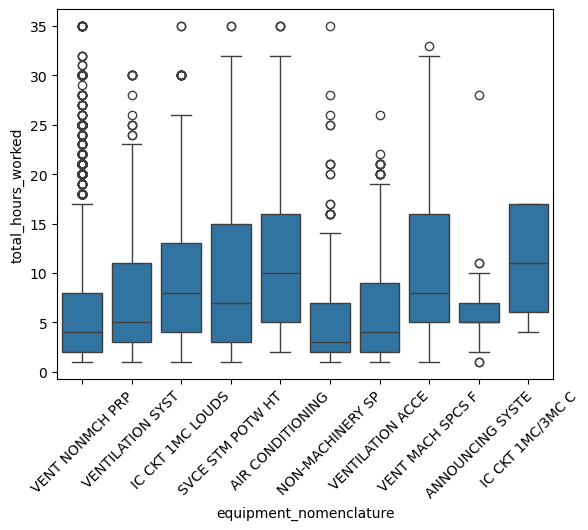

In [3]:
top10 = filtered_jobs['equipment_nomenclature'].value_counts().nlargest(10).index
df_top10 = filtered_jobs[filtered_jobs['equipment_nomenclature'].isin(top10)]

sns.boxplot(x='equipment_nomenclature', y='total_hours_worked', data = df_top10)
plt.xticks(rotation = 45)
plt.show()
#All have at least 188 records
#Shows some sign of relationship between equipment being worked on and # of hours required to complete MA 


In [ ]:
#Simple Linear Regression Using Equipment Nomenclature to Predict total_hours_worked
df_top10.loc[:,'equipment_nomenclature'] = df_top10['equipment_nomenclature'].astype('category')
model = ols('total_hours_worked ~ C(equipment_nomenclature)', data = df_top10).fit()
#model.rsquared = .045

#ANOVA
#Null: No differences between the means of individuals groups
#H1: Difference between at least 2 groups means
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


<pre>
Very little predictive power using equipment_nomenclature to predict total_hours_worked
<pre>

# Relationship between when discovered, cause, deferral reason and days_elapsed

In [ ]:
model = ols('days_elapsed ~ C(cause_code) + C(when_discovered_code) + C(deferral_reason_code)', data = jobs).fit()
model.summary() #R2 = 0.134
#also considered fitting with filtered_jobs, make a difference of .001 to r2

# Priority 
<pre>
Desirable: 46737
Highly desirable: 503
Essential: 95
Mandatory: 15

Most records in this dataset refer to MAs where it is urgent to be completed quickly.
<pre>

# Number of Jobs Opened by Month for CVN 74

Text(0.5, 1.0, 'Jobs Opened By Month On CVN 74')

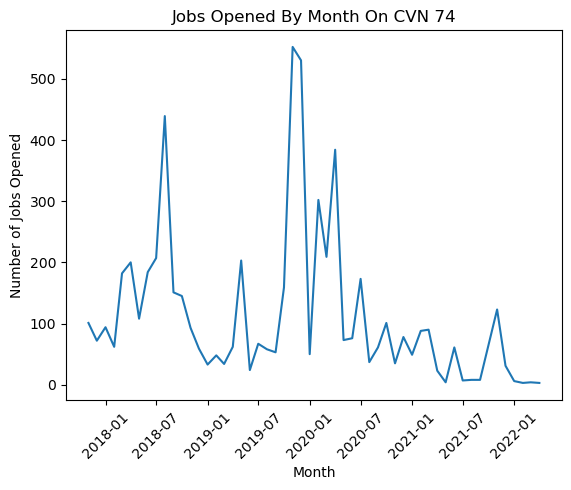

In [6]:
cvn74 = jobs[jobs['ship'] == 'CVN74'] 

monthly_counts = cvn74.groupby(cvn74['date_maintenance_action'].dt.to_period('M')).size() #Number of jobs opened each month on CVN74

monthly_counts.index = monthly_counts.index.to_timestamp() #Handles TypeError: float() argument must be a string or a real number, not 'Period'

plt.plot(monthly_counts.index, monthly_counts.values)
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel("Number of Jobs Opened")
plt.title("Jobs Opened By Month On CVN 74")

<pre>
There appears to be some meaningful variation from month to month.
Could look into trends/changes during busier or slower times
Specifically, do jobs take longer to complete during busier times?
<pre>

In [7]:
#Ideas Related to Time and The Number of Jobs Being Worked On Over Time


#Add variable showing # of jobs going on at the beginning of the MA 
#Add variable showing # of jobs that occur with the interval of the MA (date_maintenance_action ---> date_closing)
#For these variables, need to look at the job's ship. Also could look to subset further to work_center

# Next Ideas
<pre>
Predict when_discovered, cause, or deferral_reason
Cases for Each:

deferral_reason: Relatively balanced variable
Knowing why jobs get deferred in advance could help forecast for given types of jobs.
As specific personnel and work centers have specialties, additional information about why a job most often gets pushed back could help personnel plan. 
For example, knowing that a type of job often gets delayed for lack of material could lead to more effort towards montoring supply counts.


cause: Knowing the cause for a type of variable can help us enhance efforts in these areas. 
Cons: Normal wear and tear and Other make up the majority of the records for this variable. 

when_discovered: 
Relatively balanced 
Also, the top 2 most frequent are insightful - Normal operation and during inspection


Predict Engineered Variable: Binary, supplies required (Y/N)

Predict Engineered Variable: Job Took Longer than 8 hours to Complete (Y/N)
<pre>

# Idea: Predict deferral_reason
<pre>
Variables that Could Be Meaningful Predictors:

ship
cause_code
csmp_narrative_summary, equipment_nomenclature
location
priority_code, safety_code, status_code, component_status
when_discovered_code
work_center 
def_narrative, nondef_narrative
type_of_availability_needed


Number of jobs open at that time: One level is Due to ships' force work backlog
<pre>

# Ideas for Enhancing Text Features
<pre>
equipment_nomenclature, csmp_narrative_summary: Vectorization and then grouping most similar entries. Idea: reduce categories from >2100 to ~ 100
def_narrative
<pre>

# Plotting The Distribution for Hours Worked

0.311

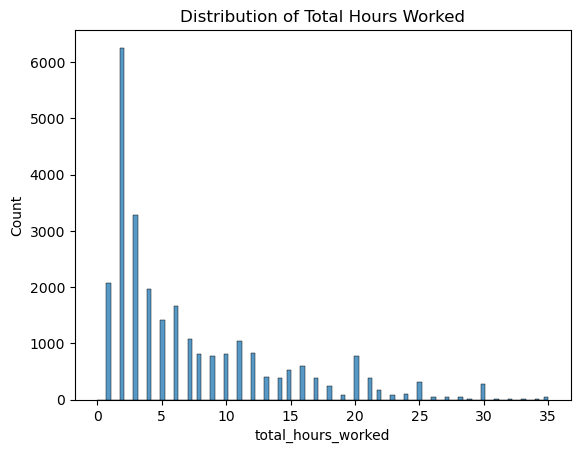

In [8]:
traditional_jobs = jobs[(jobs['hours_worked_flag'] != True) & (jobs['job_status'] != 'Open')]  #~ 27k records
#Only consider closed jobs that did not have outlier hours worked
sns.histplot(data=traditional_jobs, x='total_hours_worked', bins=100)
plt.title("Distribution of Total Hours Worked")

#Most jobs only take a few hours

#Considering jobs that did not have outlier hours worked, 31.1% of jobs took more than 8 hours to complete
(traditional_jobs['total_hours_worked'] > 8).mean().round(3)

# Plotting the Distribution of Days Elapsed

0.631

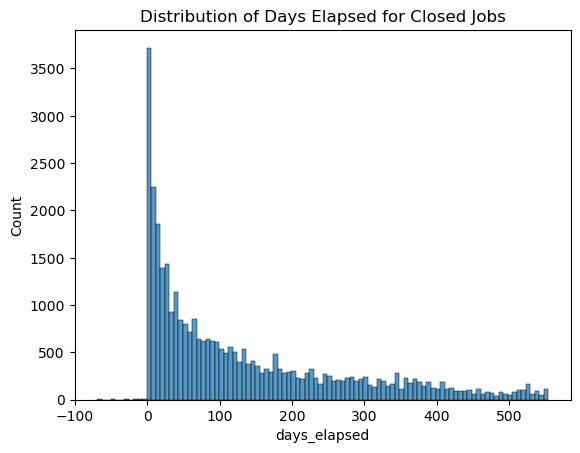

In [9]:
closed_jobs = jobs[(jobs['days_elapsed_outlier'] != True) & (jobs['job_status'] != 'Open')]  #~ 38k records

#Only consider closed jobs that were completed
sns.histplot(data=closed_jobs, x='days_elapsed', bins=100)
plt.title("Distribution of Days Elapsed for Closed Jobs")

(closed_jobs['days_elapsed'] > 30).mean().round(3) #55% of closed jobs took more than 50 days to complete
#76% of closed jobs took more than 10 days to complete

# Takeaway
<pre>
63% of closed jobs take over 30 days to become closed. This is when we remove days_elapsed outliers and only consider Closed jobs.
However, less than a third of the jobs take more than 8 hours (a full work day) to complete.

We could also see from the plots that there is a discrepency between the number of days elapsed and the total number of hours worked.

Also, deferral_reason_code:
35% due to lack of material
24% due to ship's force work backlog/operational priority
14% other/NA
13% lack of facilities/ capabiltiies
10% For ship's force overhaul

It seems that a bulk of the time spent for jobs to be closed is due to supply wait time or operational backlog.

Factors influencing operational backlog: Number of concurrent jobs being worked on
Factors influencing supply wait time: The types of parts being ordered, the quantity of parts, where parts are being ordered from, when the parts are ordered. 

<pre>

# -------------------------------Supply EDA------------------------------------

# Relationship between Supply Days Waiting and Total Days Elapsed

In [ ]:
#There are multiple part orders associated with a job. We should look at the one that takes the longest to complete, making the assumption
#that a job cannot be completed until all parts have been received. 